# K-means Classifier | Olympic Athletes from Rio
Dane Hamlett, UC Davis MSBA '18

<p id="toc"></p>
## Table of Contents

   - <a href="#one">Introduction</a>
   - <a href="#two">Import Libraries</a>
   - <a href="#three">Import Data</a>
   - <a href="#four">Explore Data</a>
   - <a href="#five">K-means Modeling</a>
   - <a href="#six">Model Validation</a>  
   - <a href="#seven">Conclusion</a>

<hr style="width:50%;">
## <a id="one">Introduction</a>
<p><a href="#toc">Jump to top</a></p>

The K-means classifier is one of the most popular clustering algorithms in machine learning. Data points are clustered around a centroid (average) of similar points with continuous features, based on the number of clusters selected (*k*). The elbow method and silhouette plots can be used to evaluate the quality of the clustering.
<p></p>
The K-means algorithm follows these four steps:
1. Randomly pick *k* centroids from the sample, as initial cluster centers
2. Assign each sample to the nearest centroid
3. Move the centroids to the samples that were assigned to it
4. Repeat steps 2 and 3, until cluster assignments stop changing, or the maximum number of iterations is reached

<p></p>
Distance between data points in a cluster is measured by the squared Euclidean distance between two points x and y in *m*-dimensional space. The K-means algorithm will minimize the within-cluster SSE (Sum of Square Errors), also known as cluster intertia.
<p></p>
For this demonstration we will attempt to cluster athletes from several different sports, who participated in the 2016 summer olympics, in Rio. We'll start be identifying sports that may be comprised of athletes with unique body types, and we will use the K-means classifier to see if the algorithm can identify clusters that correlate to these sports.
<p></p>
<br>
*This notebook was built, leveraging examples from <a href="https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939" target="_blank">Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition, by Sebastian Raschka, and Vahid Mirjalili</a>, and leverages <a href="https://github.com/flother/rio2016" target="_blank">athlete data from the 2016 summer olympics in Rio</a>, that was aggregated by Matt Riggott.*

<hr style="width:50%;">
## <a id="two">Import Libraries</a>
<p><a href="#toc">Jump to top</a></p>

In [170]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm

# Visualization specifications
color = sns.color_palette()
plt.style.use('ggplot')
%matplotlib inline

# Warning message supression
warnings.simplefilter("ignore")

<hr style="width:50%;">
## <a id="three">Import Data</a>
<p><a href="#toc">Jump to top</a></p>

In [171]:
# Import primary athlete data & preview data
# This data is publicly available here: https://github.com/flother/rio2016

# Import data
athletes = pd.read_csv("https://raw.githubusercontent.com/flother/rio2016/master/athletes.csv")

# Modify attributes
athletes['age'] = (pd.to_datetime('today') - pd.to_datetime(athletes['date_of_birth'])).dt.days
athletes['sex'] = athletes['sex'].transform(lambda x: 1 if x == 'male' else 0)

# Filter data frame
athletes = athletes.drop(['nationality', 'date_of_birth', 'gold', 'silver', 'bronze', 'info'],axis=1)
columns = ['weight','height']
athletes = athletes.dropna(subset=columns)

# Preview data
athletes.head()

,id,name,sex,height,weight,sport,age
0,736041664,A Jesus Garcia,1,1.72,64.0,athletics,17653
1,532037425,A Lam Shin,0,1.68,56.0,fencing,11468
2,435962603,Aaron Brown,1,1.98,79.0,athletics,9395
3,521041435,Aaron Cook,1,1.83,80.0,taekwondo,9906
4,33922579,Aaron Gate,1,1.81,71.0,cycling,9943


<hr style="width:50%;">
## <a id="four">Explore Data</a>
<p><a href="#toc">Jump to top</a></p>

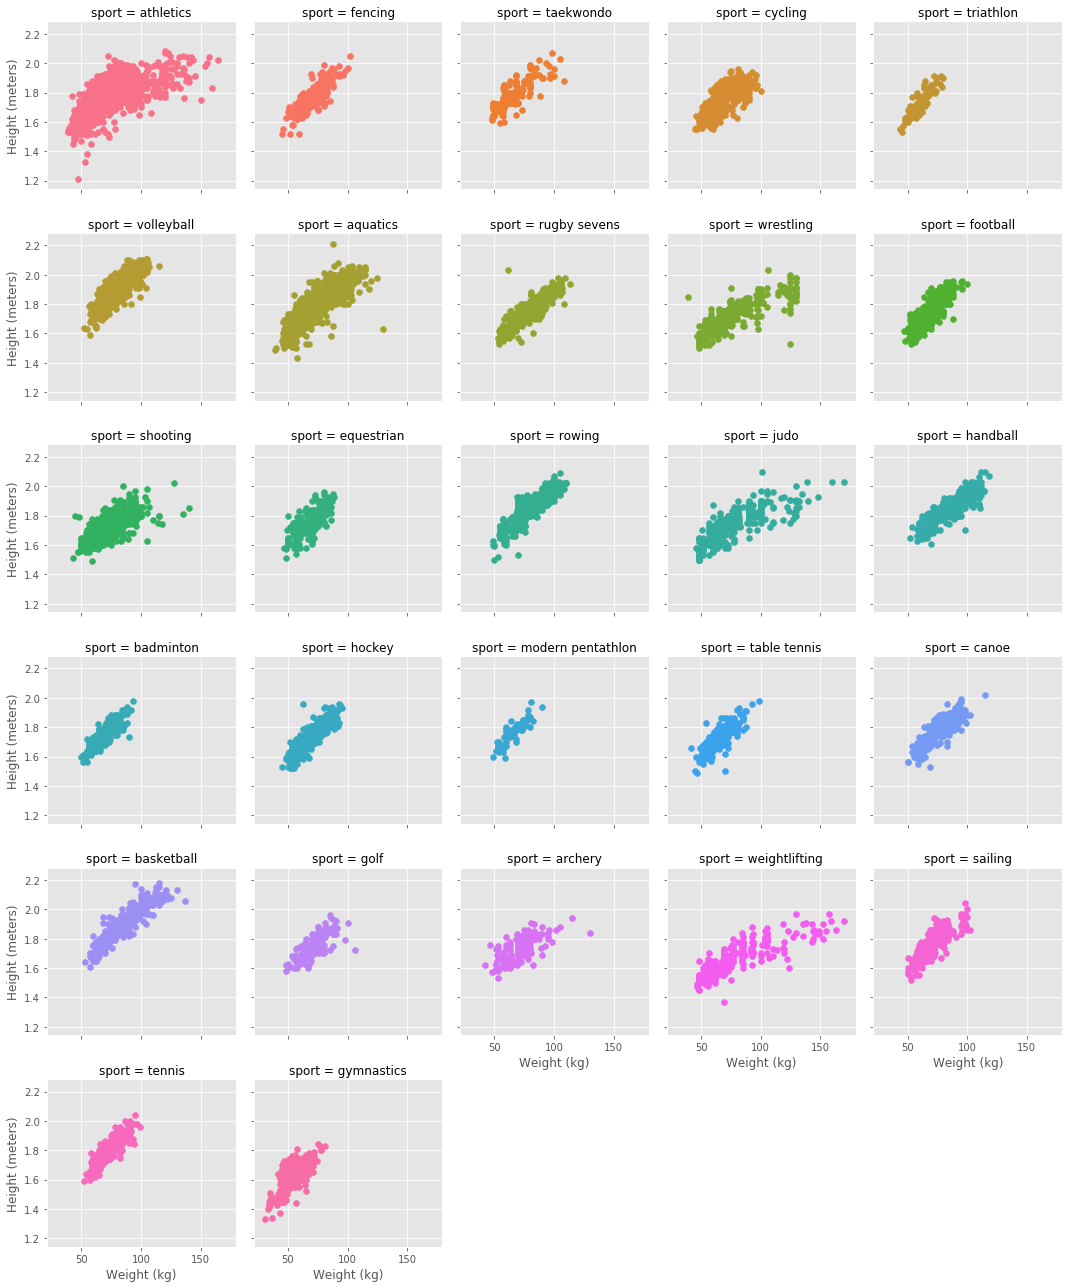

In [172]:
# Create a facet grid scatter plot to identify initial trends
cx = sns.FacetGrid(athletes, col='sport', col_wrap=5, size=3, aspect=1, hue='sport')
cx = cx.map(plt.scatter, 'weight', 'height')
cx.set_axis_labels('Weight (kg)', 'Height (meters)')
plt.show()

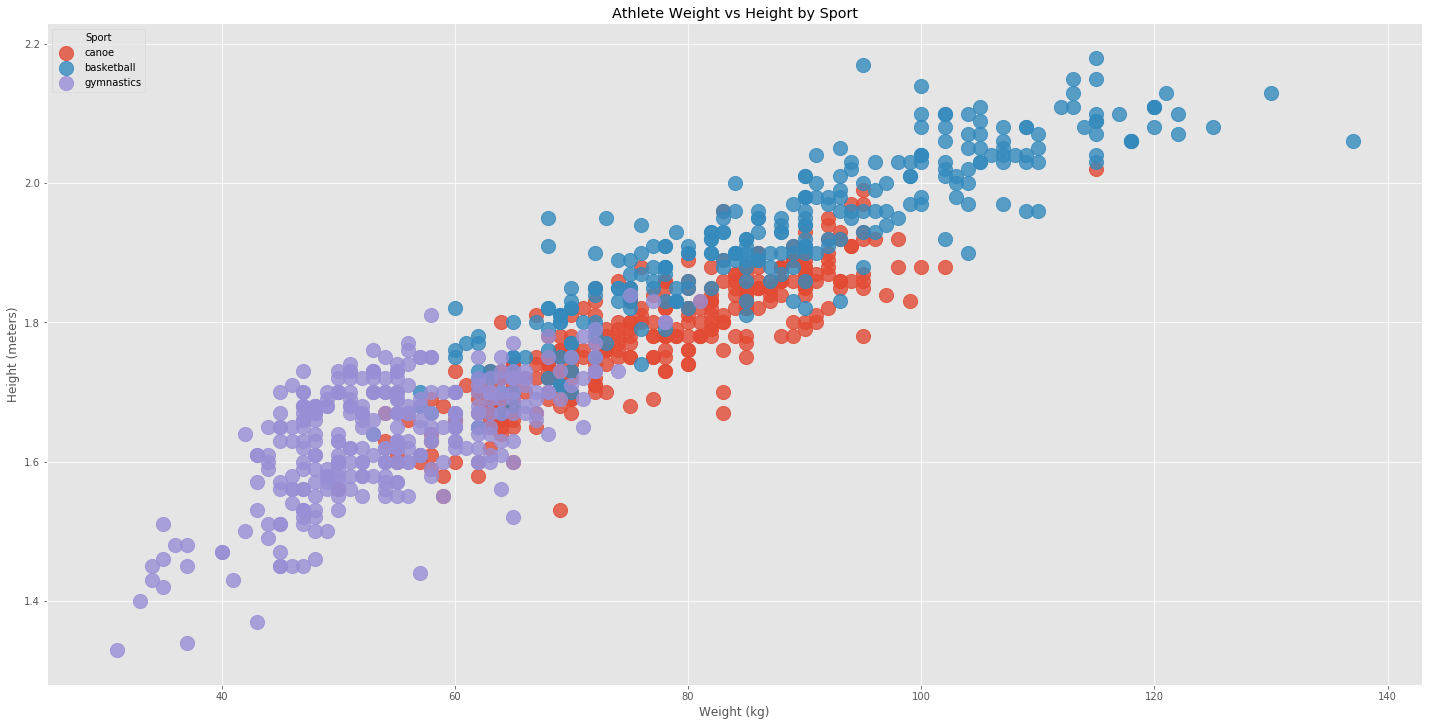

In [173]:
# Select sports where unique body types may be more common
sport = ['canoe','gymnastics','basketball']
athletes = athletes[athletes['sport'].isin(sport)]

# Generate plot to identify initial segmentation by sport
ax = sns.lmplot(x='weight', y='height', data=athletes, hue='sport', fit_reg=False, size=10, aspect=2, legend=False, scatter_kws={"s": 200})
ax.set(xlabel='Weight (kg)', ylabel='Height (meters)', title="Athlete Weight vs Height by Sport")
plt.legend(loc='upper left', title='Sport')
plt.show()

Based off of the analysis above, we have selected three sports that have relatively distinct body types (based off of height and weight combinations). This will be key as we develop our model, to determine how closely our results will correlate with our initial segments.

<hr style="width:50%;">
## <a id="five">K-means Modeling</a>
<p><a href="#toc">Jump to top</a></p>

In [174]:
# Create clustering data frame
cluster = athletes[["weight","height"]].copy()

# Convert data frame to array
cluster = cluster.values

# Preview data
cluster

array([[ 85.  ,   1.82],
       [ 90.  ,   1.94],
       [ 82.  ,   1.85],
       ..., 
       [ 47.  ,   1.65],
       [ 67.  ,   1.65],
       [ 49.  ,   1.58]])

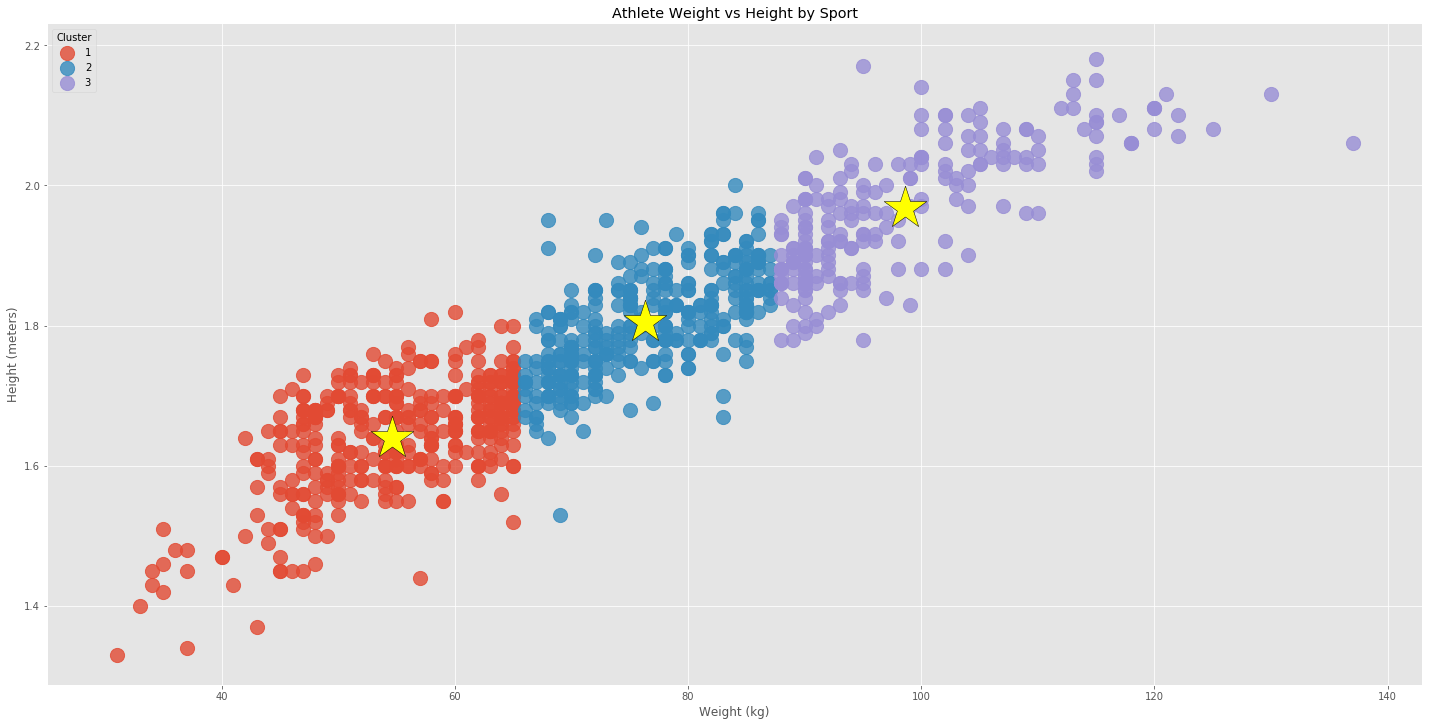

In [175]:
# Run K-Means classifier
km = KMeans(n_clusters=3,
    init='k-means++',
    n_init=30,
    max_iter=3000,
    tol=1e-04,
    random_state=10)
y_km = km.fit_predict(cluster)

# Merge clusters for final clustered data frame
weight_1 = cluster[y_km == 1, 0]
height_1 = cluster[y_km == 1, 1]
cluster_1 = pd.DataFrame({'weight':weight_1, 'height':height_1, 'cluster':1})

weight_2 = cluster[y_km == 0, 0]
height_2 = cluster[y_km == 0, 1]
cluster_2 = pd.DataFrame({'weight':weight_2, 'height':height_2, 'cluster':2})

weight_3 = cluster[y_km == 2, 0]
height_3 = cluster[y_km == 2, 1]
cluster_3 = pd.DataFrame({'weight':weight_3, 'height':height_3, 'cluster':3})

cluster_final = pd.concat([cluster_1, cluster_2, cluster_3], axis=0)

# Generate plot to identify spread of driving metric distributions
dx = sns.lmplot(x='weight', y='height', data=cluster_final, hue='cluster', fit_reg=False, size=10, aspect=2, legend=False, scatter_kws={"s": 200})
dx.set(xlabel='Weight (kg)', ylabel='Height (meters)', title="Athlete Weight vs Height by Sport")
plt.legend(loc='upper left', title='Cluster')

# Plot centroids
plt.scatter(km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=2000, marker='*',
    c='yellow', edgecolor='black',
    label='centroids')
plt.show()

After running the K-means classifier algorithm, we have generated three distinct clusters. Centroids have been selected for each respective cluster, and we can start to identify clear groupings of body types.

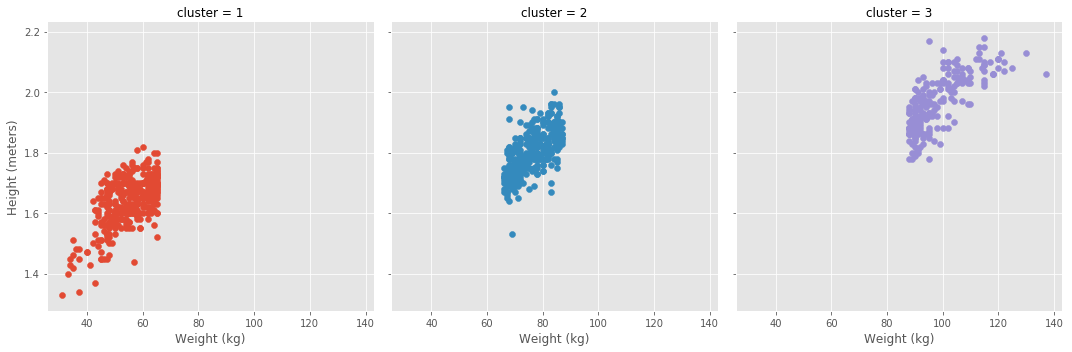

In [176]:
# Create a facet grid scatter plot to sgement each cluster
dx = sns.FacetGrid(cluster_final, col='cluster', col_wrap=3, size=5, aspect=1, hue='cluster')
dx = dx.map(plt.scatter, 'weight', 'height')
dx.set_axis_labels('Weight (kg)', 'Height (meters)')
plt.show()

Through leveraging a facet-grid plot, we can visually see how each of the clusters have been segmented, individually. Though the color shades are different, we can clearly see that these clusters acutally correspond to the original three sports we selected in our model. We can infer that based off of an athlete's height and weight, and assuming they are participating in one of these three events, we should be able to predict what sport an athlete may participate in.

<hr style="width:50%;">
## <a id="five">Model Validation</a>
<p><a href="#toc">Jump to top</a></p>

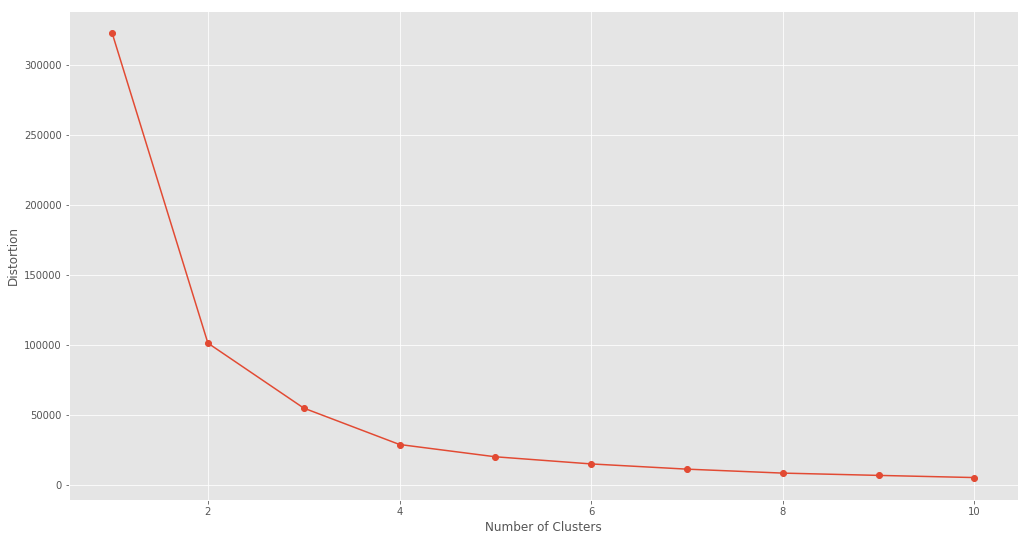

In [177]:
# Create an empty list to handle distortion details
distortions = []

# Test model on set of integers to identify optimial k value
for i in range(1, 11):
    km = KMeans(n_clusters=i,
        init='k-means++',
        n_init=30,
        max_iter=3000,
        tol=1e-04,
        random_state=10)
    km.fit(cluster)
    distortions.append(km.inertia_)

# Plot results
plt.figure(figsize=(17,9))
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In order to quantify the quality of the unsupervised K-means clustering method, we need to optimize around the within-cluster SSE (also known as distortion). We can compare the performance of different K-means clusters through the elbow method, which allows us to estimate the optimal number of clusters (*k*). The point at which distortion increases more rapidly, is somewhere between a *k* value of 2 and 4, so 3 (which we leveraged in our model), is most likely appropriate, and corresponds back to our original groupings.

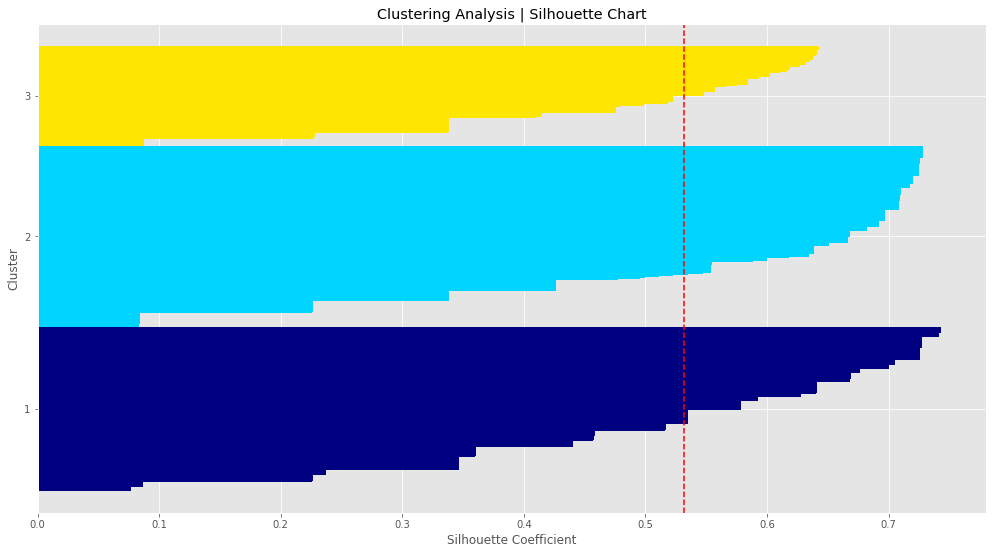

In [178]:
# Create silhouette plot to identify effectiveness of clusters
plt.figure(figsize=(17,9))
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(cluster, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor='none',
        color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

# Plot modifications and labels
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.title('Clustering Analysis | Silhouette Chart')
plt.show()

A silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the sample values in a cluster are. You can identify outliers easily, and visualize critical details of the model. As none of the silhouettes coefficients are equal to zero, the average of all coefficients is .5 < x < .6, and each of the silhouettes has a roughly similar width, this is a fairly strong clustering model.

<hr style="width:50%;">
## <a id="seven">Conclusion</a>
<p><a href="#toc">Jump to top</a></p>

As we can see, the K-means classifier can be a very strong and easy to implement algorithm for identifying clusters of data. While this is an unsupervised learning method, we can clearly see that the algorithm does work, and even allowed us to form clusters that were comparable to our original segmentation of athlete body types by sport. While scatter plots may help validate cluster effectiveness, it is equally as important to leverage more robust measures of model effectiveness through the elbow method, and silhouette plotting. As with any machine learning algorithm, it takes time to find the otpimal model, but hopefully this sheds light on a fairly straight-forward method for getting started with K-means.